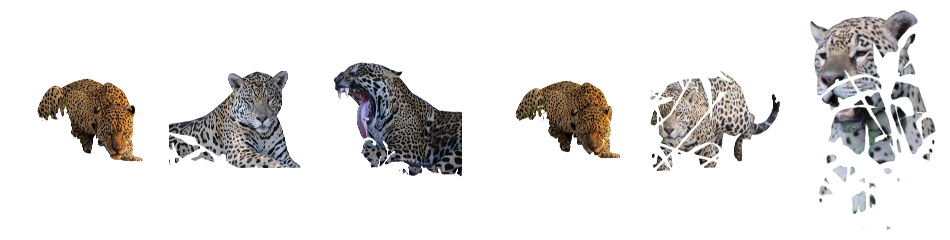

/tmp/ipykernel_12/2796898740.py:227: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/8 | Loss: 15.8592


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5c2855a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5c2855a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", l

Epoch 2/8 | Loss: 8.9564


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/8 | Loss: 5.0451


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/8 | Loss: 3.1743


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/8 | Loss: 2.1639


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5c2855a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb5c2855a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", l

Epoch 6/8 | Loss: 1.6851


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/8 | Loss: 1.4220


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/8 | Loss: 1.3645


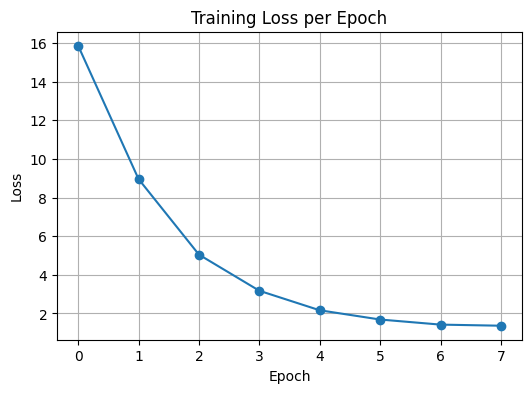

Extracting Features:   0%|          | 0/6 [00:00<?, ?it/s]

Submission saved as submission.csv


In [3]:
# ====================================================
# Imports & Config
# ====================================================
import os, random, math
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

# ====================================================
# Configuration
# ====================================================
class Config:
    seed = 42
    model_name = "convnext_small.fb_in1k"
    img_size = 224
    embedding_dim = 768
    num_classes = 0
    num_epochs = 8
    batch_size = 32
    grad_accum = 1
    lr = 1e-4
    weight_decay = 1e-2
    arcface_s = 30.0
    arcface_m = 0.5
    use_tta = True
    use_qe = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_csv = "/kaggle/input/jaguar-re-id/train.csv"
    test_csv = "/kaggle/input/jaguar-re-id/test.csv"
    train_dir = "/kaggle/input/jaguar-re-id/train/train"
    test_dir = "/kaggle/input/jaguar-re-id/test/test"

# ====================================================
# Reproducibility
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.seed)

# ====================================================
# Dataset
# ====================================================
class JaguarDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.is_test = is_test
        if not is_test and "ground_truth" in df.columns:
            unique_ids = sorted(df["ground_truth"].unique())
            self.label_map = {name: i for i, name in enumerate(unique_ids)}
            self.df["label"] = self.df["ground_truth"].map(self.label_map)
            Config.num_classes = len(unique_ids)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row.get("filename", row.get("image_id"))
        img_path = self.img_dir / img_name
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new("RGB", (Config.img_size, Config.img_size))
        if self.transform:
            img = self.transform(img)
        if self.is_test:
            return img, img_name
        return img, torch.tensor(row["label"], dtype=torch.long)

# ====================================================
# Transforms
# ====================================================
train_transform = transforms.Compose([
    transforms.Resize((Config.img_size, Config.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.0),
    transforms.RandomAffine(10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.25)
])
test_transform = transforms.Compose([
    transforms.Resize((Config.img_size, Config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ====================================================
# Model Components
# ====================================================
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return F.avg_pool2d(x.clamp(min=self.eps).pow(self.p),
                            (x.size(-2),x.size(-1))).pow(1./self.p)

class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.5):
        super().__init__()
        self.s, self.m = s, m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1,1),1.0)
        phi = cosine - self.m
        return (one_hot*phi + (1-one_hot)*cosine) * self.s

class JaguarReIDModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.backbone = timm.create_model(Config.model_name, pretrained=True, num_classes=0, global_pool="")
        self.feat_dim = self.backbone.num_features
        self.gem = GeM()
        self.bn = nn.BatchNorm1d(self.feat_dim)
        nn.init.constant_(self.bn.weight,1)
        nn.init.constant_(self.bn.bias,0)
        self.arcface = ArcFaceLayer(self.feat_dim,num_classes,Config.arcface_s,Config.arcface_m)
    def forward(self,x,label=None):
        feats = self.backbone(x)
        feats = self.gem(feats).flatten(1)
        feats_bn = self.bn(feats)
        return self.arcface(feats_bn,label) if label is not None else feats_bn

# ====================================================
# Training Engine (Fixed)
# ====================================================
def train_one_epoch(model, loader, optimizer, criterion, scaler, scheduler, device):
    model.train()
    total_loss = 0

    for step, (images, labels) in enumerate(tqdm(loader, leave=False, desc="Training")):
        images, labels = images.to(device), labels.to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(images, labels)
            loss = criterion(outputs, labels)/Config.grad_accum

        scaler.scale(loss).backward()

        if (step + 1) % Config.grad_accum == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * Config.grad_accum

    if scheduler: scheduler.step()
    return total_loss / len(loader)

@torch.no_grad()
def extract_features(model, loader, device):
    model.eval()
    feats, names = [], []
    for images, filenames in tqdm(loader, desc="Extracting Features"):
        images = images.to(device)
        f1 = model(images)
        if Config.use_tta:
            f2 = model(torch.flip(images,[3]))
            f1 = (f1+f2)/2
        feats.append(f1.cpu())
        names.extend(filenames)
    return torch.cat(feats,0).numpy(), names

# ====================================================
# Visualization
# ====================================================
def plot_training_loss(losses):
    plt.figure(figsize=(6,4))
    plt.plot(losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def visualize_samples(df,img_dir,num_samples=6):
    plt.figure(figsize=(12,4))
    for i, filename in enumerate(df['filename'].sample(num_samples)):
        img = Image.open(Path(img_dir)/filename)
        plt.subplot(1,num_samples,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# ====================================================
# Main Execution
# ====================================================
if __name__=="__main__":
    # Load CSVs
    train_df = pd.read_csv(Config.train_csv)
    test_df = pd.read_csv(Config.test_csv)

    # Visualize some training samples
    visualize_samples(train_df, Config.train_dir)

    # DataLoader
    train_dataset = JaguarDataset(train_df, Config.train_dir, train_transform)
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)

    # Model, optimizer, loss, scheduler
    model = JaguarReIDModel(Config.num_classes).to(Config.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr, weight_decay=Config.weight_decay)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs, eta_min=1e-6)

    # Training loop
    train_losses = []
    best_loss = float('inf')
    for epoch in range(Config.num_epochs):
        avg_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler, Config.device)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{Config.num_epochs} | Loss: {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "jaguar_best_model.pth")

    plot_training_loss(train_losses)

    # Inference & Submission
    model.load_state_dict(torch.load("jaguar_best_model.pth"))
    unique_imgs = sorted(set(test_df["query_image"])|set(test_df["gallery_image"]))
    test_dataset = JaguarDataset(pd.DataFrame({"filename":unique_imgs}), Config.test_dir, test_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size*2, shuffle=False, num_workers=4)

    embeddings, names = extract_features(model, test_loader, Config.device)
    embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
    sim_matrix = np.matmul(embeddings, embeddings.T)

    # Generate submission
    name_to_idx = {name:i for i,name in enumerate(names)}
    preds = []
    for _, row in test_df.iterrows():
        q_idx = name_to_idx[row["query_image"]]
        g_idx = name_to_idx[row["gallery_image"]]
        sim_score = max(0.0, min(1.0, float(sim_matrix[q_idx,g_idx])))
        preds.append(sim_score)

    pd.DataFrame({"row_id": test_df["row_id"], "similarity": preds}).to_csv("submission.csv", index=False)
    print("Submission saved as submission.csv")


In [8]:
# Install plotly in Jupyter / Kaggle
!pip install plotly --quiet



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
# ====================================================
# Interactive Visualization Extension (After Submission)
# ====================================================
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"  # Use "notebook" or "iframe_connected" in Jupyter

# Interactive t-SNE or PCA embeddings
def interactive_embeddings(embeddings, names, method="tsne"):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    if method.lower() == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        reducer = PCA(n_components=2)
    reduced = reducer.fit_transform(embeddings)

    df_embed = pd.DataFrame({
        "x": reduced[:,0],
        "y": reduced[:,1],
        "filename": names
    })

    fig = px.scatter(df_embed, x="x", y="y", hover_data=["filename"], 
                     title=f"Interactive {method.upper()} of Feature Embeddings",
                     width=800, height=600)
    fig.show()

# Interactive similarity heatmap
def interactive_similarity(sim_matrix, names, top_k=10):
    import plotly.figure_factory as ff

    if sim_matrix.shape[0] > top_k:
        sim_matrix = sim_matrix[:top_k, :top_k]
        names = names[:top_k]
    
    fig = ff.create_annotated_heatmap(
        z=sim_matrix,
        x=names,
        y=names,
        annotation_text=np.round(sim_matrix, 2),
        colorscale="Viridis",
        showscale=True
    )
    fig.update_layout(title="Interactive Cosine Similarity Heatmap", width=800, height=600)
    fig.show()


# ====================================================
# Run Interactive Visualizations
# ====================================================
# Interactive t-SNE
interactive_embeddings(embeddings, names, method="tsne")

# Interactive PCA
interactive_embeddings(embeddings, names, method="pca")

# Interactive Similarity Heatmap (top 10 images)
interactive_similarity(sim_matrix, names, top_k=10)


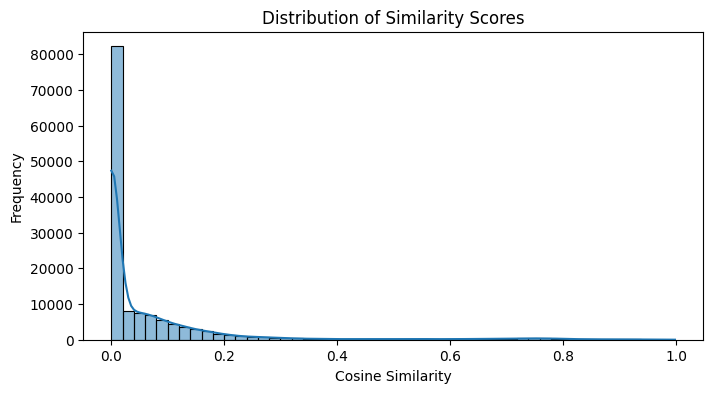

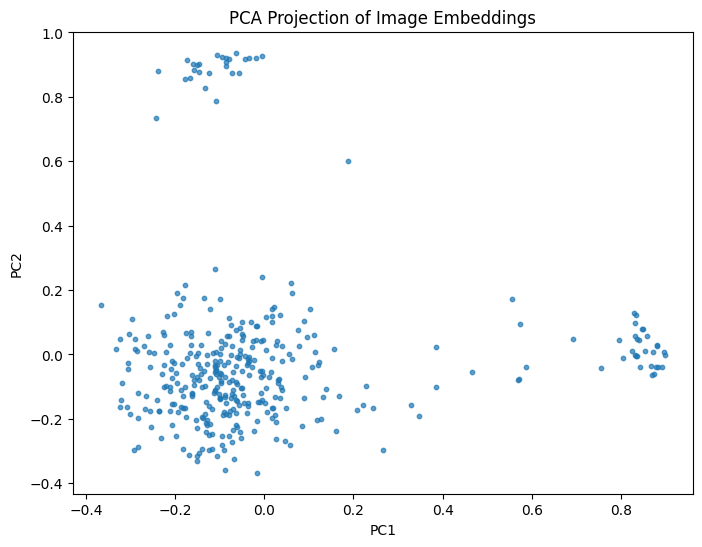

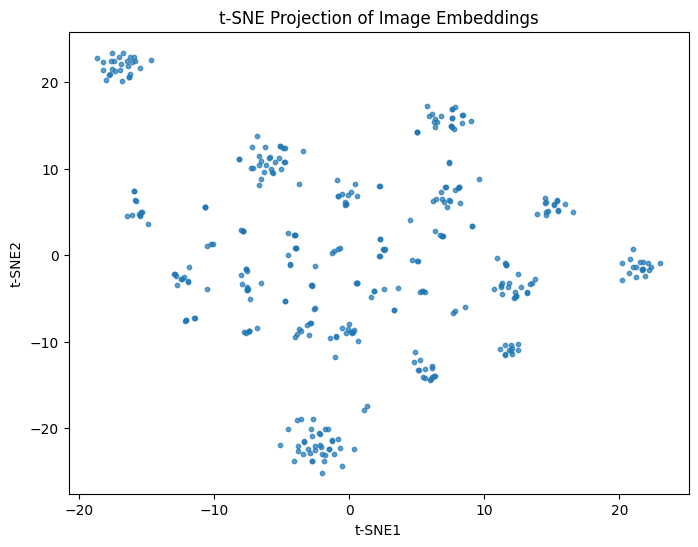

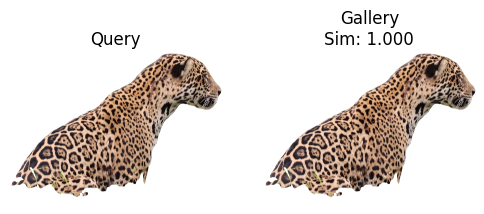

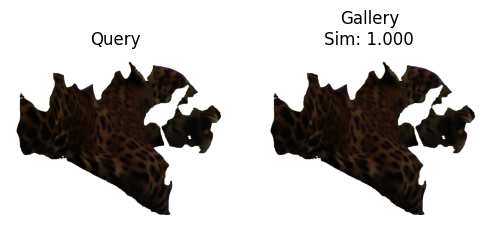

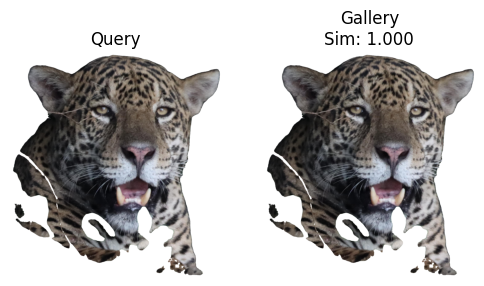

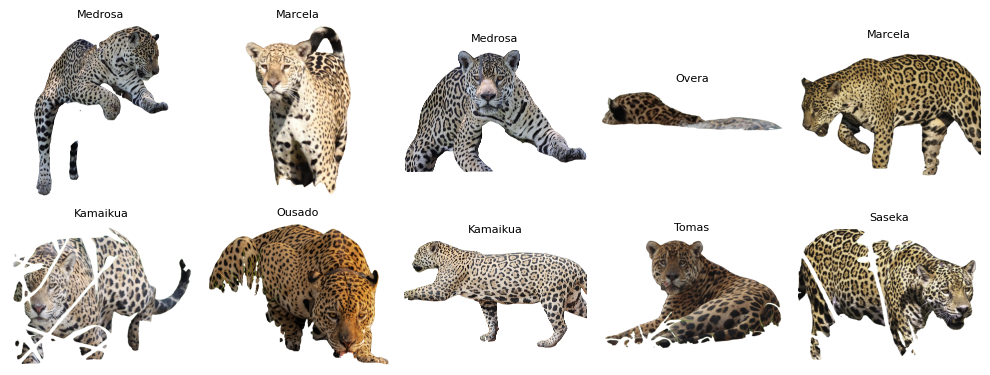

In [11]:
# ====================================================
# Extended Visualizations (After Submission)
# ====================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1️⃣ Plot Histogram of Similarity Scores
plt.figure(figsize=(8,4))
sns.histplot(preds, bins=50, kde=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

# 2️⃣ PCA Projection of Embeddings
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_pca[:,0], emb_pca[:,1], s=10, alpha=0.7)
plt.title("PCA Projection of Image Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 3️⃣ t-SNE Projection for Visualizing Clusters (fixed)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_tsne[:,0], emb_tsne[:,1], s=10, alpha=0.7)
plt.title("t-SNE Projection of Image Embeddings")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()


# 4️⃣ Show Top Similar Pairs (from similarity matrix)
def show_top_similar(sim_matrix, names, top_k=5):
    for i in range(top_k):
        idx_max = sim_matrix.argmax()
        q_idx, g_idx = np.unravel_index(idx_max, sim_matrix.shape)
        sim_score = sim_matrix[q_idx, g_idx]
        
        fig, axes = plt.subplots(1,2, figsize=(6,3))
        img_q = Image.open(Path(Config.test_dir)/names[q_idx])
        img_g = Image.open(Path(Config.test_dir)/names[g_idx])
        axes[0].imshow(img_q)
        axes[0].set_title("Query")
        axes[0].axis('off')
        axes[1].imshow(img_g)
        axes[1].set_title(f"Gallery\nSim: {sim_score:.3f}")
        axes[1].axis('off')
        plt.show()
        
        # Zero out this max to get next top
        sim_matrix[q_idx, g_idx] = -1

show_top_similar(sim_matrix.copy(), names, top_k=3)

# 5️⃣ Random Sample Grid with Labels (if available)
def plot_random_grid(df, img_dir, num_rows=2, num_cols=5):
    sample_files = df['filename'].sample(num_rows*num_cols).values
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, num_rows*2))
    for i, ax in enumerate(axes.flatten()):
        img = Image.open(Path(img_dir)/sample_files[i])
        ax.imshow(img)
        ax.axis('off')
        if 'ground_truth' in df.columns:
            ax.set_title(str(df[df['filename']==sample_files[i]]['ground_truth'].values[0]), fontsize=8)
    plt.tight_layout()
    plt.show()

plot_random_grid(train_df, Config.train_dir)


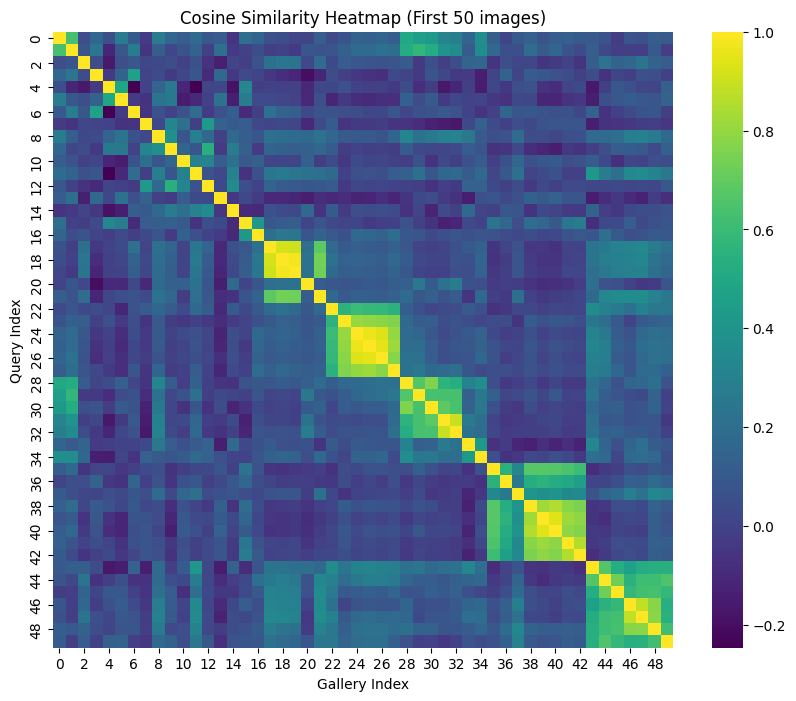

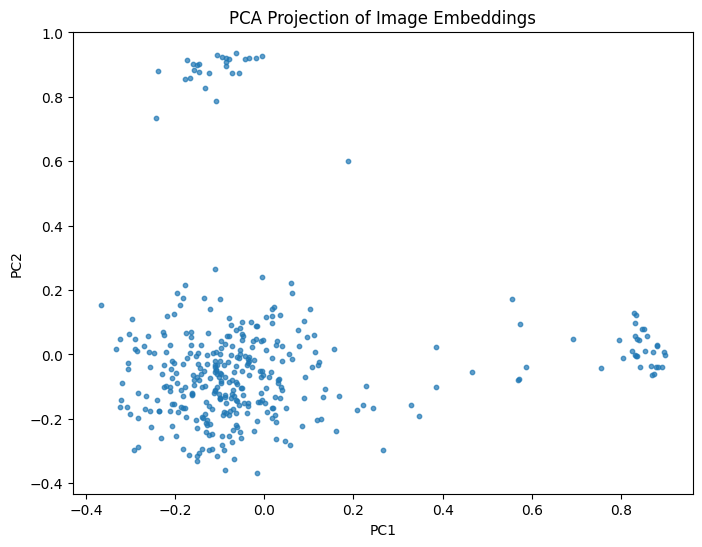

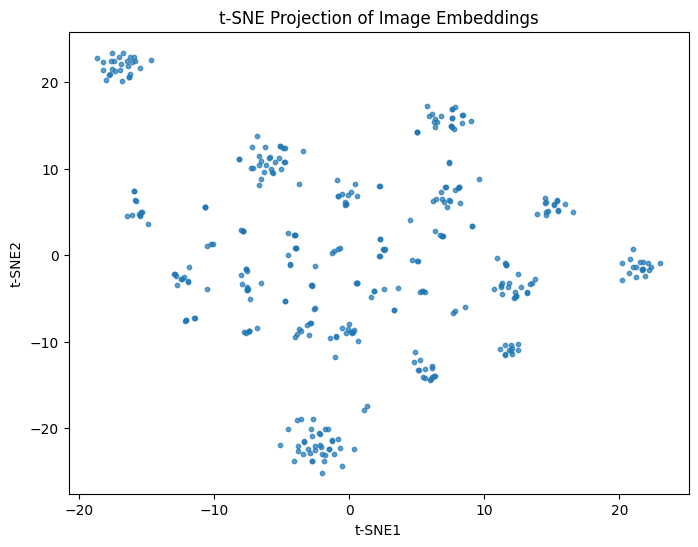

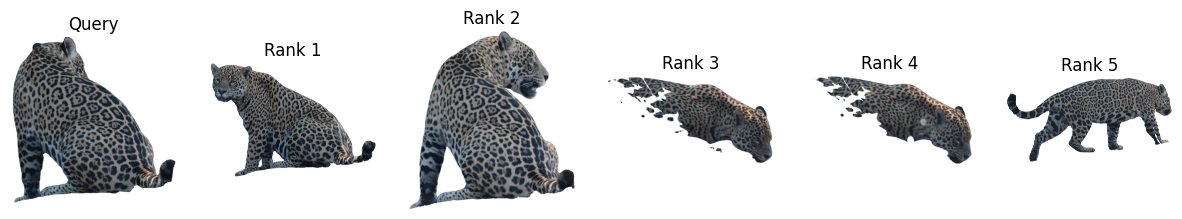

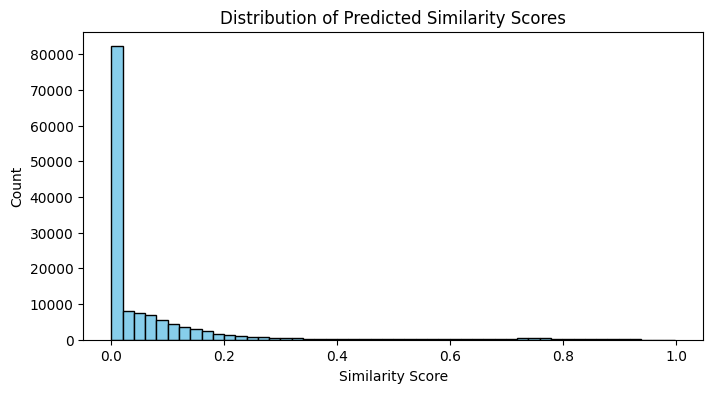

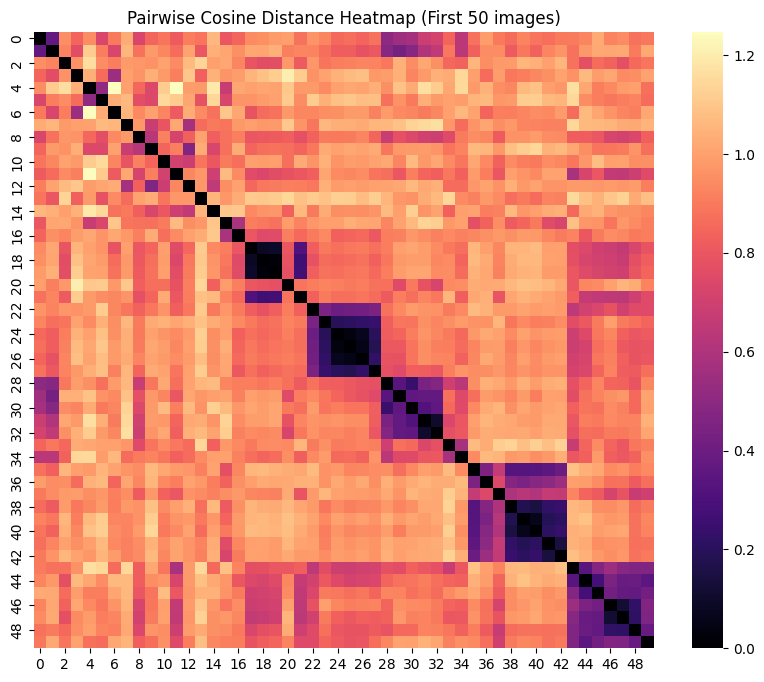

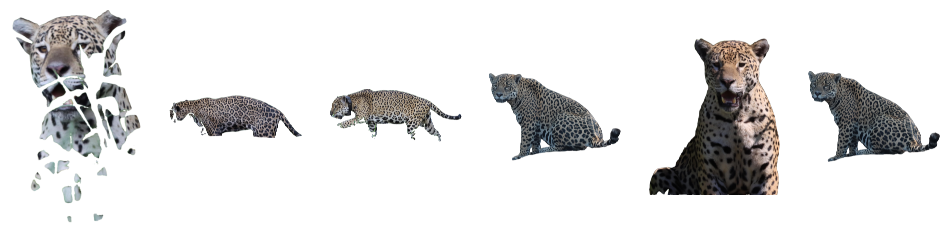

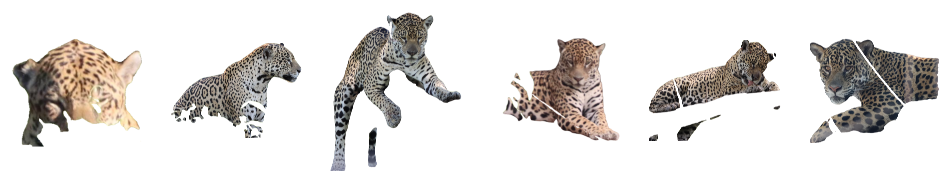

In [12]:
# ====================================================
# Interactive & Static Visualizations (After Submission)
# ====================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import numpy as np

# 1️⃣ Visualize Similarity Matrix (Cosine Similarity Heatmap)
plt.figure(figsize=(10,8))
sns.heatmap(sim_matrix[:50,:50], cmap='viridis')  # visualize first 50 images for clarity
plt.title("Cosine Similarity Heatmap (First 50 images)")
plt.xlabel("Gallery Index")
plt.ylabel("Query Index")
plt.show()

# 2️⃣ PCA Projection of Embeddings
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(embeddings)
plt.figure(figsize=(8,6))
plt.scatter(emb_pca[:,0], emb_pca[:,1], s=10, alpha=0.7)
plt.title("PCA Projection of Image Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 3️⃣ t-SNE Projection for Clustering
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
emb_tsne = tsne.fit_transform(embeddings)
plt.figure(figsize=(8,6))
plt.scatter(emb_tsne[:,0], emb_tsne[:,1], s=10, alpha=0.7)
plt.title("t-SNE Projection of Image Embeddings")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()

# 4️⃣ Top Similar Images for Random Queries
def show_top_similar_images(query_idx, top_k=5):
    sorted_idx = np.argsort(-sim_matrix[query_idx])[:top_k+1]  # include query itself
    plt.figure(figsize=(15,3))
    for i, idx in enumerate(sorted_idx):
        filename = names[idx]
        img = Image.open(Path(Config.test_dir)/filename)
        plt.subplot(1, top_k+1, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Rank {i}" if i>0 else "Query")
    plt.show()

# Example: visualize top-5 for a random query
import random
rand_query = random.randint(0, len(names)-1)
show_top_similar_images(rand_query, top_k=5)

# 5️⃣ Distribution of Similarity Scores
plt.figure(figsize=(8,4))
plt.hist(preds, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.show()

# 6️⃣ Visualize Embedding Distances (Pairwise)
dist_matrix = pairwise_distances(embeddings, metric='cosine')
plt.figure(figsize=(10,8))
sns.heatmap(dist_matrix[:50,:50], cmap='magma')
plt.title("Pairwise Cosine Distance Heatmap (First 50 images)")
plt.show()

# 7️⃣ Random Sample Images from Dataset
def visualize_samples(df, img_dir, num_samples=6):
    plt.figure(figsize=(12,4))
    for i, filename in enumerate(df['filename'].sample(num_samples)):
        img = Image.open(Path(img_dir)/filename)
        plt.subplot(1,num_samples,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_samples(train_df, Config.train_dir, num_samples=6)
visualize_samples(pd.DataFrame({"filename":names}), Config.test_dir, num_samples=6)
